# Problem wieloagentowy

### Autorzy:

Diana Misiaczyńska,
Emilia Myrta

Tematyką szóstego, i tym samym ostatniego, projektu są problemy wieloagentowe. Środowisko, które wybrałyśmy to `Simple Reference` z `PettingZoo`. Jest ono cześcią nastawionego na komunikację agentów zestawu `Multi Particle Environments (MPE)`.

Wybranym przez nas algorytmem rozwiązującym problem jest `DQN` z biblioteki `stable_baselines3`.

Środowisko `Simple Reference` charakteryzuje się następującymi cechami:
- występuje tam kilku agentów (np. 3), którzy poruszają się po dwuwymiarowej przestrzeni.
- każdy agent ma przypisany "referencyjny obiekt" (landmark), który jest jego celem, lecz agent nie wie, który obiekt nim jest.
- jeden z agentów posiada wiedzę, który landmark przypisany jest do którego agenta — i musi to zakomunikować pozostałym.
- wymusza komunikację i współpracę między agentami.

In [ ]:
pip install pettingzoo supersuit stable-baselines3

In [ ]:
from pettingzoo.mpe import simple_reference_v3

In [3]:
env = simple_reference_v3.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()

    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample()

    env.step(action)
env.close()

Dodajemy wszystkie potrzebne importy.

In [ ]:
import supersuit as ss
from stable_baselines3 import DQN
from pettingzoo.mpe import simple_reference_v3
from pettingzoo.utils.conversions import aec_to_parallel
import matplotlib.pyplot as plt
import numpy as np

Inicjalizujemy środowisko PettingZoo i konwertujemy do ParallelEnv. Następnie korzystamy z wrapperów supersuit do wyrównania przestrzeni obserwacji i akcji. Potrzebna jest także konwersja środowiska do formatu kompatybilnego z Gym.

In [5]:
env = simple_reference_v3.env()
parallel_env = aec_to_parallel(env)

parallel_env = ss.pad_observations_v0(parallel_env)
parallel_env = ss.pad_action_space_v0(parallel_env)

env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
env = ss.concat_vec_envs_v1(env, 4, num_cpus=1, base_class="stable_baselines3")

Dostosowujemy hiperparametry modelu DQN oraz ustawiamy liczbę timesteps na 10 000.

In [ ]:
model = DQN('MlpPolicy', env, verbose=1,
            learning_rate=1e-3,
            gamma=0.9, # współczynnik dyskontowania
            exploration_fraction=0.1, # część epizodów, w których agent będzie eksplorował
            exploration_final_eps=0.01, # minimalna wartość epsilon
            target_update_interval=1000, # co ile kroków aktualizuje się sieć docelowa
            train_freq=1, # jak często i ile razy aktualizowane są wagi
            gradient_steps=1,
            batch_size=32,
            buffer_size=100000)

model.learn(total_timesteps=100000)

Następnie testujemy wytrenowany model. Oprócz tego wygładzamy wyniki za pomocą średniej kroczącej.


In [7]:
obs = env.reset()
total_rewards = []
num_episodes = 1000
for i in range(num_episodes):
    total_reward = 0
    done = [False for _ in range(env.num_envs)]
    while not all(done):
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        total_reward += sum(rewards) # suma nagród w danym epizodzie
    total_rewards.append(total_reward)

env.close()

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50
smoothed_rewards = moving_average(total_rewards, window_size)

Na koniec wizualizacjemy krzywą uczenia.

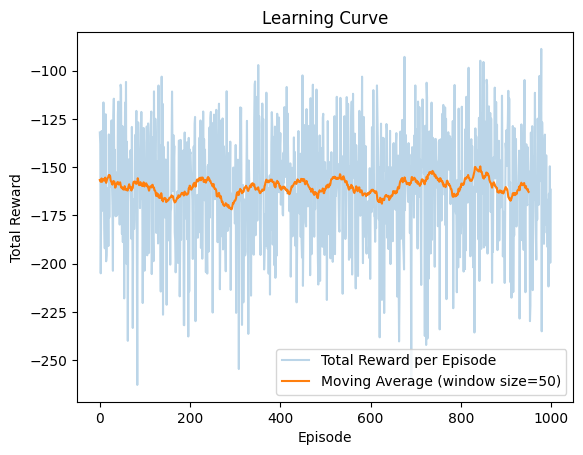

In [8]:
plt.plot(total_rewards, alpha=0.3, label='Total Reward per Episode')
plt.plot(smoothed_rewards, label=f'Moving Average (window size={window_size})')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curve')
plt.legend()
plt.show()